# Pipeline for the anomaly detection on the SKAB using LSTM-Autoencoder

Details regarding the SKAB one can find in the [SKAB repository](https://github.com/waico/SKAB).

In [ ]:
# libraries importing
import sys
import warnings

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

sys.path.append("..")
from core.LSTM_AE import LSTM_AE
from core.metrics import chp_score
from core.utils import create_sequences, load_preprocess_skab, plot_results

warnings.filterwarnings("ignore", category=UserWarning)

## Data

In [ ]:
Xy_traintest_list = load_preprocess_skab()

## Method

### Method initialization

In [ ]:
# hyperparameters selection
EPOCHS = 100
BATCH_SIZE = 32
VAL_SPLIT = 0.1
N_STEPS = 10
Q = 0.99  # quantile for upper control limit (UCL) selection
PARAM = [EPOCHS, BATCH_SIZE, VAL_SPLIT]

In [ ]:
model = LSTM_AE(PARAM)

### Method fitting and applying

In [ ]:
# inference
predicted_outlier, predicted_cp = [], []
true_outlier, true_cp = [], []
for X_train, X_test, y_train, y_test in Xy_traintest_list:
    # scaler init and fitting
    StSc = StandardScaler()
    StSc.fit(X_train)

    # convert into input/output
    X = create_sequences(StSc.transform(X_train), N_STEPS)

    # model fitting
    # history, model = arch(X)
    model.fit(X)

    # results predicting
    residuals = pd.Series(
        np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1)
    )
    UCL = residuals.quantile(Q) * 3 / 2

    # results predicting
    X = create_sequences(StSc.transform(X_test), N_STEPS)
    cnn_residuals = pd.Series(
        np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1)
    )

    # data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
    anomalous_data = cnn_residuals > UCL
    anomalous_data_indices = []
    for data_idx in range(N_STEPS - 1, len(X) - N_STEPS + 1):
        if np.all(anomalous_data[data_idx - N_STEPS + 1 : data_idx]):
            anomalous_data_indices.append(data_idx)

    prediction = pd.Series(data=0, index=X_test.index)
    prediction.iloc[anomalous_data_indices] = 1

    # predicted outliers saving
    predicted_outlier.append(prediction)

    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

    true_outlier.append(y_test["anomaly"])
    true_cp.append(y_test["changepoint"])

### Results visualization

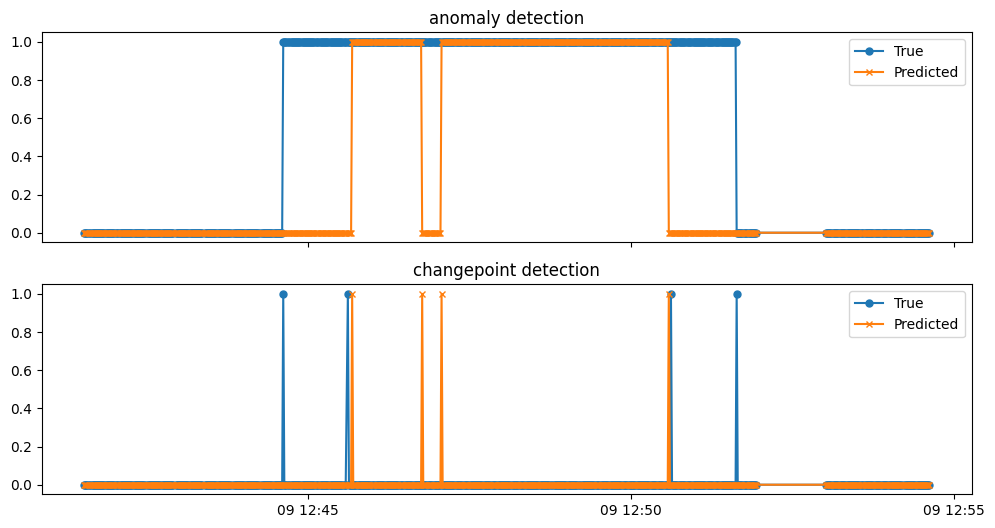

In [ ]:
# [donotremove]
plot_results(
    (true_outlier[1], predicted_outlier[1]),
    (true_cp[1], predicted_cp[1]),
)

## Evaluation (metrics calculation)

In [ ]:
import pickle

pickle.dump(
    predicted_outlier,
    open(f"../results/results-{model.__class__.__name__}.pkl", "wb"),
)

### Binary classification (outlier detection) metrics

In [ ]:
# [donotremove]
# binary classification metrics calculation
binary = chp_score(true_outlier, predicted_outlier, metric="binary")

False Alarm Rate 29.96 %
Missing Alarm Rate 25.92 %
F1 metric 0.74


### Changepoint detection metrics

In [ ]:
# [donotremove]
# average detection delay metric calculation
add = chp_score(
    true_cp,
    predicted_cp,
    metric="average_time",
    window_width="60s",
    anomaly_window_destination="righter",
)

Amount of true anomalies 127
A number of missed CPs = 88
A number of FPs = 69
Average time 0 days 00:00:17


In [ ]:
# [donotremove]
# nab metric calculation
nab = chp_score(
    true_cp,
    predicted_cp,
    metric="nab",
    window_width="60s",
    anomaly_window_destination="righter",
)

Standard  -  23.51
LowFP  -  20.11
LowFN  -  25.91
